# Deep Learning sur un problème de classification d'images d'oiseaux

In [4]:
# 2 min
!pip install -q -q -q tqdm 
!pip3 install -q -q -q torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q -q -q pandas
!pip install -q -q -q imageio
!pip install -q -q -q scikit-learn


In [5]:
%load_ext autoreload
%autoreload 2

import os
import s3fs
import shutil
import torch
from pathlib import Path
import random
import imageio.v3 as iio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [6]:
if torch.cuda.is_available() : device= torch.device("cuda:0" ) 
else : device  = "cpu"
print("Using {} device".format(device))
if device != "cpu" :
    print("nom du GPU :", torch.cuda.get_device_name(device=None))
    print("GPU initialisé : ", torch.cuda.is_initialized())

Using cuda:0 device
nom du GPU : Tesla T4
GPU initialisé :  True


## Chargement des données 

Extraction des images et fichiers utiles.

In [7]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('projet-funathon/Sujet9_deep_learning_donnees_satellites/archive.zip', 'oiseau.zip')
shutil.unpack_archive('oiseau.zip')

On se limite dans un premier temps à un problème à 2 classes.
On souhaite être en mesure ici de produire un algorithme permettant de classifier correctement des images de 2 catégories d'oiseau.

L'objet train_images_paths est une liste de l'ensemble des chemins permettant d'accéder aux images. train images labels, les labels associés à ces images (0,1). 
Le dictionnaire dic_id_to_label créé ici met en face le nom d'oiseau et le numéro du label associé. Au final 366 images d'entraînement sont à notre disposition.


In [8]:
bird_df = pd.read_csv('birds.csv')
NB_CLASSES = 2
#On se limite à 20 classes
bird_df = bird_df[bird_df['class index'] < NB_CLASSES]

train_images_paths = np.array(bird_df['filepaths'])
train_images_labels = np.array(bird_df['class index'])

# index to nom d'oiseau
nom_oiseau = np.array(bird_df.labels.unique())
dic_id_to_label = {i : oiseau for i,oiseau in zip(range(NB_CLASSES),nom_oiseau)}
dic_id_to_label

{0: 'ABBOTTS BABBLER', 1: 'ABBOTTS BOOBY'}

In [12]:
train_images_labels.shape 
train_images_paths.shape

(366,)

## Création de la classe permettant d'accéder au dataset

On crée ici la classe Custom Dataset héritant de la classe Dataset en python
Un CustomDataset sera initialisé avec l'ensemble des images_paths et ses labels précedemment présentés.

Un objet Dataset sera dit itérable dans la mesure où on pourra boucler dessus pour en récupérer les éléments. A chaque itération d'une telle boucle La fonction _getitem_  sera appelée pour accéder à un élément. Ci-dessous on demande à chaque itération de retourner un dictionnnaire dont les items (clef,valeur)  sont : 

- ('image', l'image sous forme d'array ) 
- ('label', le label associé (0,1)) 

In [13]:
class CustomDataset(Dataset):
    def __init__(self, image_paths,labels): 
        self.image_paths = image_paths
        self.labels = labels
        
    def __getitem__(self, idx):
    
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image = iio.imread(self.image_paths[idx]) 
        image = torch.tensor(np.array(image,dtype = float)/255, dtype =torch.float).permute(2,1,0)     
        label = self.labels[idx]
     
        return {"image": image, "label" : label} 
        
        
    def __len__(self):  # return count of sample we have
        return len(self.image_paths)
    


## Définition de quelques hyper paramètres

Ces hyperparamètres seront définis dans ce qui suit

In [32]:

config ={
    'n_epoch' : 100,
    'val_size' : 0.2,
    'batch_size' : 60,
    'optimizer' : "SGD",
    'lr' : 0.005,    
    'momentum' : 0.9,
    'model type': "convnet",
    'descriptif': "Entrainement avec un convnet"
}


## Création des Data Loader

Das un premier temps on va découper notre jeu d'apprentissage (les 366 images labellisées) en : 
- un jeu de d'entraînement sur lequel on  entraînera notre modèle 
- un jeu de validation ne participant pas à l'entrainement du modèle mais permettant d'en évaluer les performances

La fonction *train_test_split* de scikit learn permet de faire ce découpage. Le paramètre *val_size* de la config donne la proportion ddu jeu d'images total (entre 0 et 1) que l'on veut garder dans le jeu de validation. Le paramètre stratify permet de préciser sur quel critère on veut stratifier cette sélection aléatoire (ici les labels dans le but d'avoir un échantillon représentatif des labels de l'ensemble des images)

Lors de l'entraînement, on va en fait entrainer notre algorithme par itération sur des petits paquets d'images (appelés *batchs*). On calcule pour chacun de ces batchs l'erreur commise par l'algorithme et on modifie ses paramètres en conséquence (par descente de gradient)

Cette extraction par paquet d'images est permise par le Dataloader moyenant le remplissage du paramètre *batch_size* (cf 'batch_size' dans la config) permettant de préciser la taille des batchs que l'on souhaite avoir. Le paramètre shuffle égal à True veut dire que les images seront toutes remélangées une fois un tour total de l'ensemble des images réalisé. 
On appelle un tour complet une *epoch*.


In [34]:

batch_size =  config['batch_size']
all_dataset = CustomDataset(train_images_paths,train_images_labels)

# je découpe le data set en train et validation (20 % de validation) en stratifiant par les labels
train_indices, valid_indices = train_test_split(list(range(len(train_images_labels))), test_size=config['val_size'], stratify=train_images_labels)

train_dataset = torch.utils.data.Subset(all_dataset, train_indices)
valid_dataset = torch.utils.data.Subset(all_dataset, valid_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=80, shuffle=True, num_workers=0)


## Définition des modèles

On définit ici une classe Net (héritant de la classe module) permettant d'instancier des réseaux de neurones convolutifs.

Dans *_init_*, on définit l'ensemble des objets utilisés dans l'opération *forward*.L'opération *forward* définit la suite des opérations qui seront appliquées aux images auxquelles on appliquera un modèle de type *Net*.

Dans la fonction *forward* (qui prend en entrée une image x) on constate bien que plusieurs transformations enboitées sont successivement appliquées à l'image x en entrée.

In [16]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 4)
        self.conv4 = nn.Conv2d(32, 16, 3)
        self.conv5 = nn.Conv2d(16, 24, 3)
        self.fc1 = nn.Linear(24 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, NB_CLASSES)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)# flatten all dimensions except batch
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




On va ici définir un modèle de type réseau de neurones convolutifs. Cette structure de réseau est très utilisée lorsqu'on traite des problèmes sur les images. 
Dans le cadre classique du machine learning on fonctionne généralement en 2 étapes : 
- i) Extraction de caractéristiques sur des images (extraction des composantes principales d'une acp par exemple)
- ii) On fait passer un classifieur sur les caractéristiques extraites, ce qui permet de prédire la catégorie de l'image concernée

Les réseaux de neurones convolutifs fonctionnent sur le même principe si ce n'est que l'extraction des caractéristiques est complètement internalisée par le réseau, on apprend à notre réseau à extraire ces caractéristiques lui même.

Cette extraction de caractéristique est permise par l'usage d'opérations de convolution et de pooling permettant de réduire la dimension de l'image.

Dans un premier temps on définit les différents objets qui vont être utiles à la construction du réseau : 

les Conv2d sont des couches convolutives appliquables à des images. Aplliquer une convolution revient à appliquer un filtre sur l'image. Un filtre est une matrice réelle généralement de petite dimension. Appliquer ce filtre au pixel (i,j) revient à effectuer la moyenne pondérée par les coefficients du filtre des pixels au voisinage de (i,j), le voisinage étant défini par la dimension du filtre.

Les Conv2D prennent en paramètre : 

- i) le nombre de channels en entrée : la première convolution prend 3 channels en entrée car c'est elle qui sera appliquée à notre image de départ qui est de dimension 3 (channels : Red Blue Green) X 246 (Hauteur) x 256 (Largeur)
- ii) le nombre de Channels en sortie : la première couche convolutive aura 6 channels de sortie. Ce qui veut dire que 6 filtres seront générée par cette couche donnant naissance à 6 images en sortie résultantes de l'application des 6 filtres sur l'image 3 x256 x 256 initiale.
- iii) Kernel size  la dimension des filtres appliqués

Et plein d'autres que l'on peut consulter sur la documentation Pytorch (voir stride et padding par exemple)

Les coefficients contenus dans les filtres font partis des paramètres du modèle, ce sont eux qui seront entraînés, *i.e* modifiés à chaque itération de notre entrainement.

L'opération *Maxpool* est également une opération de réduction de la dimension, mais elle ne contient pas de paramètres ! Le maxpool applique un filtre à une image en entrée.  Appliquer ce filtre au pixel (i,j) revient à rechercher le coefficient maximum au voisinage de (i,j), le voisinage étant défini par la dimension du filtre. 

L'extraction de caractéristiques de l'image est en fait réalisé par l'enchaînement de couches convolutives. 1 couche convolutive est composée d'une Conv2D, d'un Maxpool et de l'application d'une fonction non linéaire (non paramètrée, ici la Rectified Linear unit relu). 
L'entraînement modifiera les paramètres de cet enchaînement de couches (en l'occurance les valeurs dans les filtres de convolution) de telle sorte que l'extraction de caractéristiques soit la plus pertinente possible au regard du problème posé.

Après passages des 5 couches convolutives sur l'image initiale 24 * 4 * 4 = 384 caractéristiques on été extraites. 
Les couches *Linear* permettent de construire le classifieur permettant par la suite de trancher entre le label 0, ou 1 pour l'image considérée. On notera par ailleurs que la sortie du réseau à la même dimension que le nombre de classes. Cette sortie de dimension 2 représente en fait le score attribué à telle ou telle classe par le modèle permettant de décider si l'image appartient à la classe 0 ou la classe 1.




## Test Modèle


Pour créer un modèle à partir de la Classe Net définie si dessous, rien de plus simple net  = Net()
permet de créer un modèle que l'on appellera net de la classe Net.

In [17]:
net = Net()

On peut voir la structure de notre réseau en ecxecutant la ligne ci dessous

In [18]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=384, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


La fonction ci-dessous permet d'obtenir le nombre de paramètres de notre modèle.
Notre petit modèle contient en fait 75374 ce qui dépasse largement l'ordre de grandeur usuel du nombre de paramètres généralement recnontré en Machine Learning "classique".


In [20]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

get_n_params(net) 

75734

#### **Exercice** : essayer de comprendre précisément d'où viennent ces 75734 paramètres !

## Représenter les images

Ci dessous  une fonction permettant d'afficher une image d'oiseau

In [21]:
def montrer_image(image):
    img = image.permute(2,1,0)
    img = np.array(img)
    plt.imshow(np.array(img))
    plt.show()


Ci-dessous on utilise la fonction précédente pour afficher des images du jeu d 'entraînement aléatoirement en itérant sur le train loader défini supra.

In [22]:
t = iter(train_loader)
dico = next(t)
images =dico["image"]
labels = dico["label"]

tensor(0)
ABBOTTS BABBLER


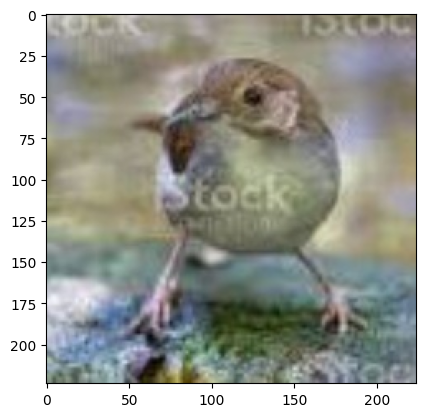

tensor(0)
ABBOTTS BABBLER


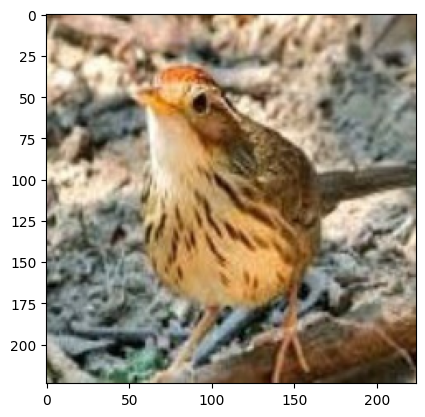

tensor(1)
ABBOTTS BOOBY


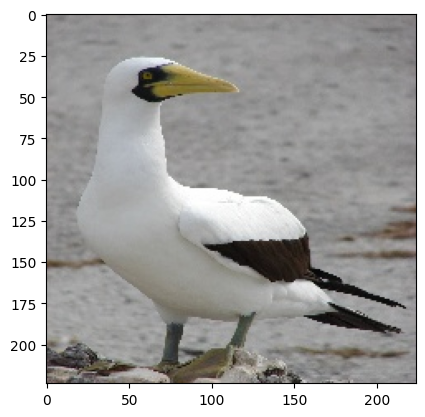

tensor(1)
ABBOTTS BOOBY


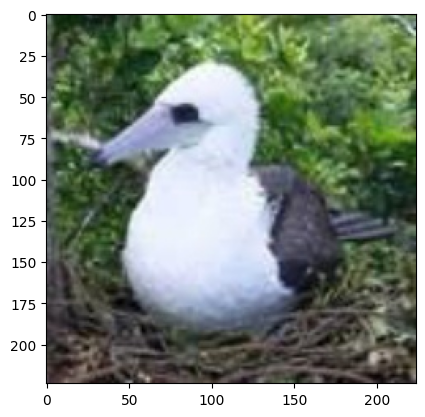

tensor(0)
ABBOTTS BABBLER


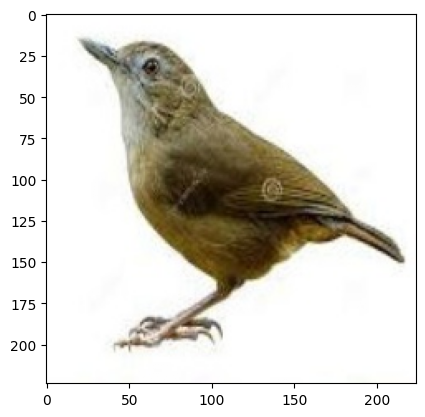

In [23]:
for i in range(5):
    print(labels[i])
    print(dic_id_to_label[int(labels[i])])
    montrer_image(images[i])


## Entrainement du modèle

Comme dit précedemment, entraîner le modèle revient à modifier, itération par itération les paramètres de notre modèle afin que ce dernier soit le plus pertinent possible dans la tâche de classification qu'il doit réaliser.
Une itération consiste en :

1) Récupération d'un batch d'images
2) Calcul de l'erreur de classification commise par le modèle sur le batch (l'erreur est une fonction de ses paramètres)
3) Calcul du gradient de l'erreur
4) Descente du gradient, *i.e* on bouge les paramètres dans la direction opposée du gradient calculé précedemment pour abaisser l'erreur commise par le modèle. Le taux d'apprentissage  permet de définir l'amplitude du mouvement dans cette direction

In [24]:
net  = Net()

La structure des réseaux de neuronse est telle que l'on peut envoyer les calculs effectués sur des GPUS, ce qui accèlere grandement le temps de calcul
Comparer la différence de temps d'execution en initiant la variable device à "cuda:0" ( ce qui veut dire que les calculs seront lancés sur GPU)

In [27]:
if torch.cuda.is_available() : device= torch.device("cuda:0" ) 
device

device(type='cuda', index=0)

Ou en l'initialisant à "cpu" ce qui veut dire que les calculs qui suivent seront lancés sur cpu

In [28]:
# device ="cpu"
#device

**Lancement de l'entraînement**

In [ ]:
# define net

optimizer = optim.SGD(net.parameters(), lr=config['lr'], momentum=config['momentum'])

net = net.to(device)

entropy = nn.CrossEntropyLoss() 

liste_loss = []
liste_acc_val = []
for epoch in range(config['n_epoch']):  
        
        net = net.to(device)
        running_loss = 0.0

        t= tqdm(train_loader, desc="epoch %i" % (epoch+1),position = 0, leave=True)
        epoch_loop = enumerate(t)

        for i, data in epoch_loop:

            taille_batch = data['image'].shape[0]
            images = data['image']
            labels  =  data['label']

            
            images, labels = images.to(device), labels.to(device)

            pred = net(images)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            loss = entropy(pred,labels)
            
            loss.backward() # calculer le gradient
            optimizer.step() # avancer dans le sens du gradient calculé

            del images, labels, pred
            running_loss += loss.item()

            if (i+1) % 5 == 0:  
                # ici enregistrement de la loss sur le train, sur le validation et envoi des résultats à wnandb
                
                liste_loss.append(running_loss)

                # validation
                ech_val = iter(valid_loader)
                dico = next(ech_val)
                images =dico["image"]
                labels =dico["label"]

                pred = torch.argmax(net(images.to(device)),dim =1)
                labels = labels.to(device)
                
                acc_val =round(100*int(torch.sum(pred == labels).cpu())/int(np.array(labels.size())),2)
                liste_acc_val.append(acc_val)
                t.set_description("epoch %i, 'mean loss: %.6f','acc.val: %.2f'" % (epoch+1,running_loss/10,acc_val))
                t.refresh()
                
                running_loss =0


epoch 6:  60%|██████    | 3/5 [00:20<00:13,  6.94s/it]

**Attention** : selon la configuration il faut parfois beaucoup d'epochs pour voir la loss diminuer, ne désespérez pas !

Si l'entraînement avance trop lentement, réouvrez un autre service Tensorflow et essayez de mettre en place la partie "Un autre jeu d'images pour s'amuser" Infra

## Evaluation du réseau entraîné

Lors de l'entraînement, les moyennes de la loss sur le jeu d'entrâinement et de la précision obtenue sur le jeu de validation sont enregistrées tous les 5 batchs dans :
- liste_loss 
- liste_acc_val 

On peut donc les représenter graphiquement

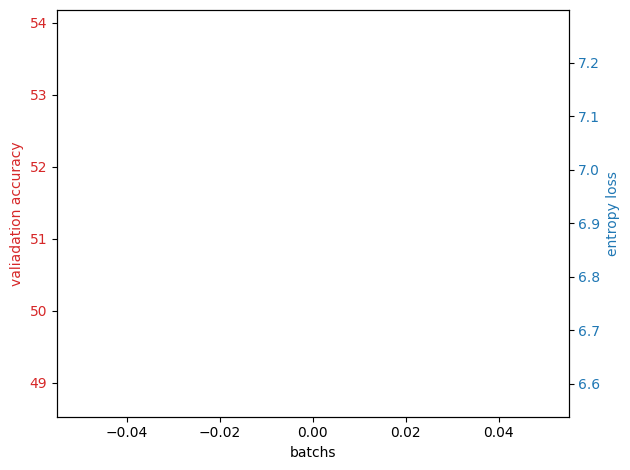

In [30]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('batchs')
ax1.set_ylabel('valiadation accuracy', color=color)
ax1.plot(liste_acc_val, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('entropy loss', color=color)  # we already handled the x-label with ax1
ax2.plot(liste_loss, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

On constate qu'à partir d'un certain nombre de batchs, la précision obtenue sur le jeu de validation se stabilise, on peut alors arrêter l'entraînement à ce moment là

On peut calculer la matrice de confusion associée à l'algorithme entraîné précedemment

In [27]:
t = iter(valid_loader)
dico = next(t)

images =dico["image"]
labels =dico["label"]

pred = np.array(torch.argmax(net(images.to(device)),dim =1).cpu())
labels = np.array(labels)

print(pred) 
print(labels)

confusion_matrix(pred,labels)

[1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0
 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1]
[1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0
 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1]


array([[33,  3],
       [ 3, 35]])

In [28]:
dic_id_to_label

{0: 'ABBOTTS BABBLER', 1: 'ABBOTTS BOOBY'}

On constate que (remplir les  ??): 
- La majorité des images du jeu de validation sont correctement classées par notre algorithme
- ?? images du jeu de validation sont classées parmi les 0 par notre algorithme à tort
- ?? images du jeu de validation sont classées parmi les 1 par notre algorithme à tort

## Que faire par la suite ?

Jouer sur les différents hyperparamètres (dans config). 
Quels sont les impacts sur les résultats du :
- Nombre d'élements par batch ?
- Nombre d'epochs ?
- Learning rate ?
- Momentum ?

Que se passe t'il si on augmente le nombre de classes d'oiseau à prédire ? (param NB_CLASSES)

## Un autre jeu d'images pour s'amuser

Ici on va charger un autre jeu d'image, de chat et de chien

In [28]:
fs.get('projet-funathon/Sujet9_deep_learning_donnees_satellites/train.zip', 'chat_chien.zip')
shutil.unpack_archive('chat_chien.zip', extract_dir="chat_chien")

In [48]:
dic_label_to_id  = {"cat":0, "dog" :1}
train_images_file = os.listdir("chat_chien/train")

train_images_paths = ["chat_chien/train/"+path for path in train_images_file]
train_images_labels = [ dic_label_to_id[st[0:3]] for st in train_images_file]


La liste des chemins de fichiers pointant vers les images et la liste des labels ayant été définie, en exercice veuillez essayer de reproduire les différentes étapes introduites précedemment. a savoir :
1) Création de la classe dataset
2) Création des train loader et valid_loader (essayer d'afficher les images avec la fonction montrer image par la suite )
3) Création du modèle
4) Entraînement du modèle
5) Evaluation

## Fine tuning

In [ ]:
# montrer conv entrainées
# montrer quelques images satellites, faire des comptages dessus etc..